# DETECCIÓN DE OBJETOS DE CLASES NO PRE-ENTRENADAS

Para la mejora del proceso de detección de eventos de cumpleaños se entrenará una red YOLO sobre imagenes de velas de cumpleaños. Este tipo de objetos no ha sido preentrenado en los modelos YOLO v8 proporcionados por Ultralytics.


# 0. Importación packages y constantes

In [23]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

# Packages propios
from utils.objectdetection import ObjectDetectionHelper
from utils.graphdbmanipulation import ImagesGraphDB
from utils.imagesmanipulation import ImageHelper

In [5]:
# Rutas de interés
PATH_IMAGENES_A_ANALIZAR = "./resources/images/Movil-S21"
PATH_MODELO_YOLO = "./models/yolov8x.pt"
PATH_MODELO_YOLO_CANDLE_LIGHTS = "./models/yolov8x_candle_light.pt"
PATH_LABELS_REF_FILE ='./resources/reference_labels/custom_labels.csv'
PATH_OBJECT_GML_FILE = './outputs/graph_databases/graph_OBJECTS.gml'
PATH_OBJECT_CANDLES_GML_FILE = './outputs/graph_databases/graph_OBJECTS_CANDLES.gml'
PATH_DETECTED_LABELS = './outputs/detected_objects/Movil-S21_labels_predicted_CUSTOM/labels'


# 1. Entrenamiento de red YOLO

Se entrena la red YOLO para detectar llamas de velas sobre un conjunto de 100 imágenes.

In [6]:
# Load a pretrained YOLO model (recommended for training)
model = YOLO(model=PATH_MODELO_YOLO)

# Train the model using the 'coco128.yaml' dataset for 3 epochs
results = model.train(data='./resources/YOLO_yaml/yolo_v8_candle_light.yaml', epochs=10, batch=10,name='./models/yolov8x_candle_light')

# Evaluate the model's performance on the validation set
results = model.val()


New https://pypi.org/project/ultralytics/8.0.80 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.53  Python-3.10.11 torch-1.13.1+cpu CPU
yolo\engine\trainer: task=detect, mode=train, model=./models/yolov8x.pt, data=./resources/YOLO_yaml/yolo_v8_candle_light.yaml, epochs=10, patience=50, batch=10, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=./models/yolov8x_candle_light, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, 

# 2. Detección de "velas" en imágenes

A partir del nuevo modelo obtenido especializado en encontrar "llamas de velas" en imagenes se analizan todas las imagenes de estudio de cara poder detectar velas de cumpleaños y poder "cribar" de un mejor modo eventos de cumpleaños.

In [19]:
objectdetector = ObjectDetectionHelper()
objectdetector.detectionTrainedClasses(PATH_MODELO_YOLO_CANDLE_LIGHTS,PATH_IMAGENES_A_ANALIZAR,0.2)


image 1/1 C:\Users\dcsj\Repositorios\UOC_TFM\image_classifier\resources\images\Movil-S21\20210724_100218.jpg: 640x480 (no detections), 1865.6ms
Speed: 0.0ms preprocess, 1865.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
4 labels saved to runs\detect\predict\labels

image 1/1 C:\Users\dcsj\Repositorios\UOC_TFM\image_classifier\resources\images\Movil-S21\20210724_104730.jpg: 480x640 (no detections), 2408.3ms
Speed: 0.0ms preprocess, 2408.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
4 labels saved to runs\detect\predict\labels

image 1/1 C:\Users\dcsj\Repositorios\UOC_TFM\image_classifier\resources\images\Movil-S21\20210724_104736.jpg: 480x640 (no detections), 2932.7ms
Speed: 1.0ms preprocess, 2932.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
4 labels saved to runs\detect\predict\labels

image 1/1 C:\Users\dc

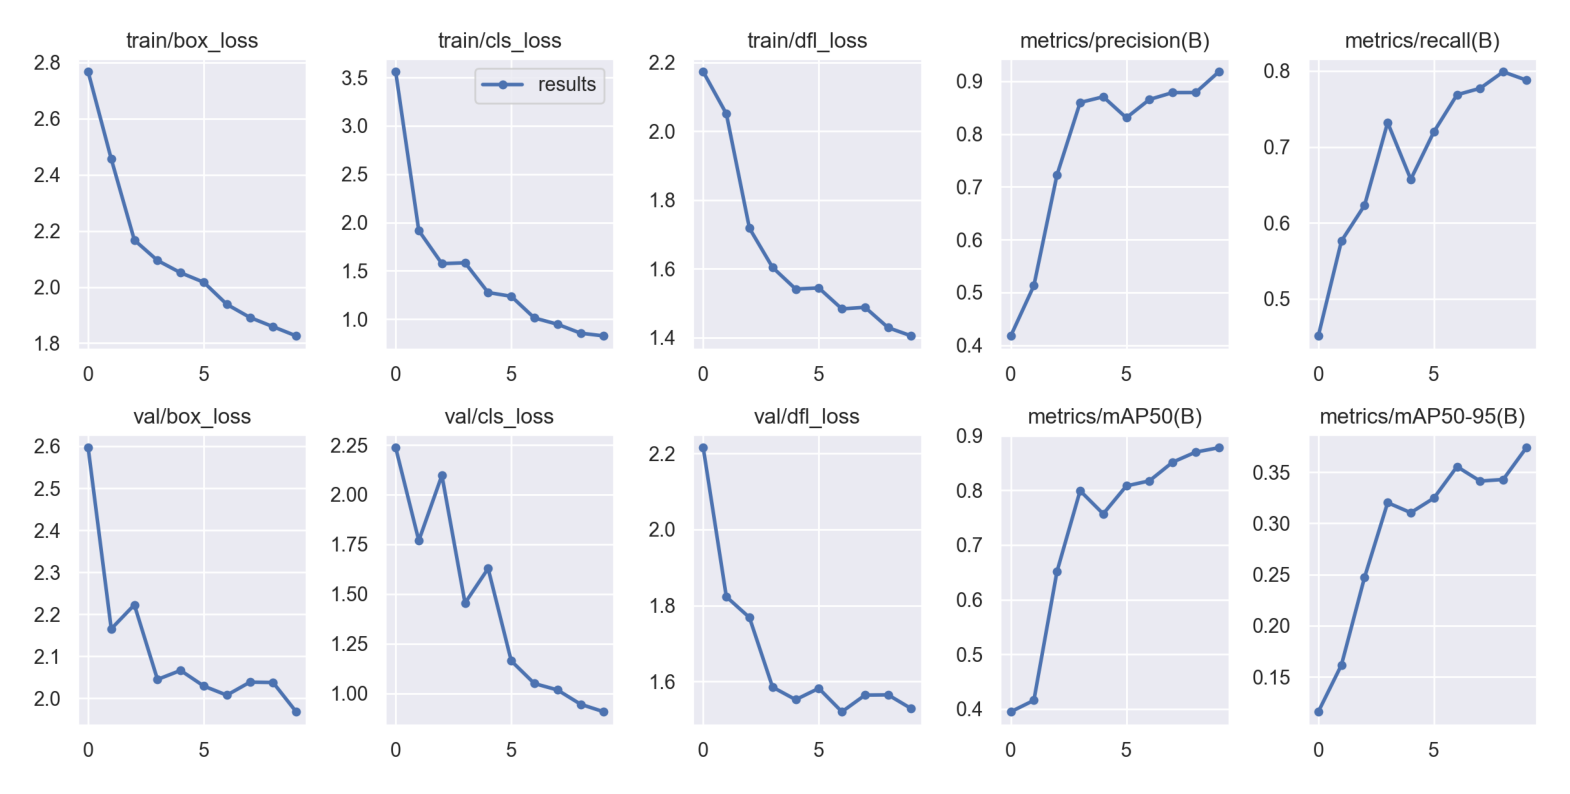

In [31]:
# Se muestran los resultados del entrenamiento y validaci
%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 20))
ax.axis('off')
img = np.asarray(Image.open('./outputs/models_train_val_results/yolov8x_candle_light/results.png'))
ax.imshow(img)

# 3. Análisis de resultados

In [20]:
# Se cargan los datos desde un fichero gml de los objetos detectados
imagesGraphDB = ImagesGraphDB()
imagesGraphDB.load_graph_from_gml_file(PATH_OBJECT_GML_FILE)

In [21]:
# Se cargan el grafo con los objetos detectados en cada imagen
imagesGraphDB.load_graph_from_yolo_detected_objects_txt_files(PATH_LABELS_REF_FILE,PATH_DETECTED_LABELS)
# Se guarda el grafo en la carpeta de "outputs" en fichero gml
imagesGraphDB.write_gml_file(PATH_OBJECT_CANDLES_GML_FILE)

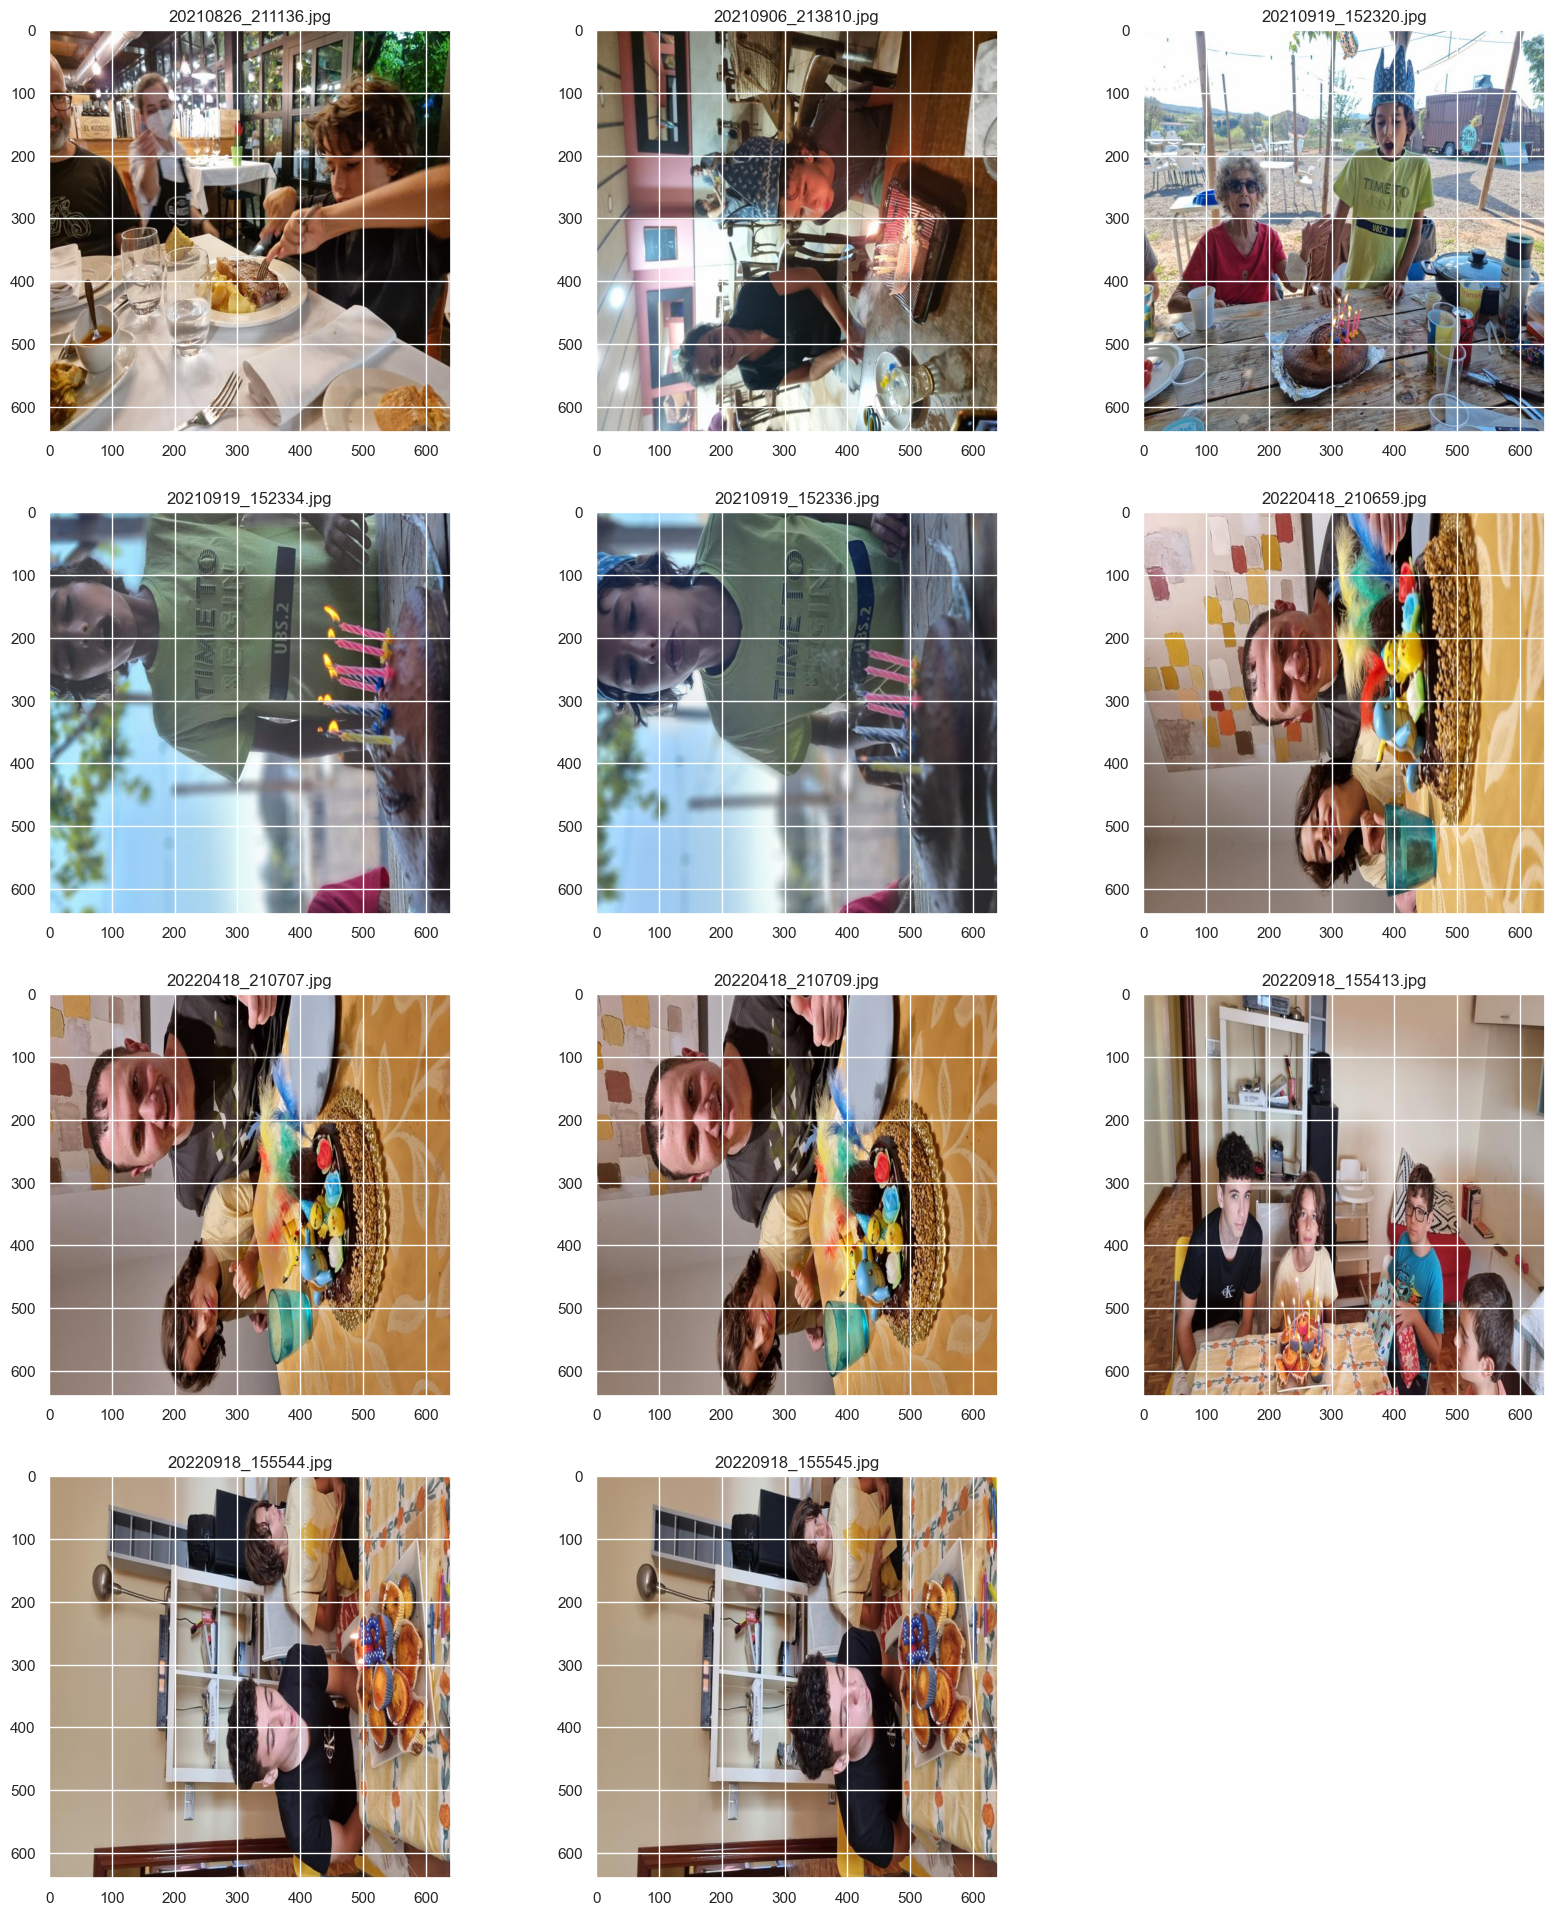

In [21]:
# Se obtiene las imágenes del grafo que se relacionan con los nodos "person" y "cake"
object_classes_to_filter = ['person','cake','candle_light'] # Se cogerán las imagenes con pasteles, personas y velas encendidas
neighbors_cake = imagesGraphDB.get_images_containing_list_object_types(object_classes_to_filter)
cake_images_filepath_list = []
cake_images_filename_list = []
for neighbor_cake in neighbors_cake:
    cake_images_filepath_list.append(os.path.join(PATH_IMAGENES_A_ANALIZAR+'_resized',neighbor_cake))
    cake_images_filename_list.append(neighbor_cake)

# Se cargan las imágenes en formato PIL en una lista pora poderlas mostrar en un grid
images_rgb_list= []
for i, image in enumerate(cake_images_filepath_list):
    image_rgb = Image.open(image)
    images_rgb_list.append(image_rgb)

# Se muestran las imagenes en un grid usando un metodo propio del helper de imágenes
%matplotlib inline
ImageHelper.display_images(images_rgb_list,columns=3,max_images=20,label_font_size=12)

Se obtienen las imágenes de cumpleaños, pero aparecen también una comida debido a que se confunde un trozo de carne con un pastel y también hay un pastel que no tiene velas y es por otra celebración. Con la combinación de estos tres items 'person','cake' y 'candle_light'. En general los resultados son buenos al detectarse mas de una foto de todos los cumpleaños celebrados sobre un conjunto de más de mil fotos.